<div style="text-align: right;">
最適化ソルバーSQBM+ 体験ハンズオン用資料<br>
2022年8月5日
</div>

<h1>演習：N クイーン問題</h1>

この Notebook では、比較的単純な組み合わせ最適化問題である N クイーン問題を題材に、問題をどのように Azure Quantum で扱うことができる QUBO に落とし込むのか、どのように東芝 SBM を利用して解くのかについて説明します。

---
<h1 style="color:#204080">0. 事前準備</h1>

<h2 style="color:#3060C0">0.1. 必要モジュールのインポート</h2>

まず、コードの実行に必要となる準備を行います。
先ほどのチュートリアルでは最適化問題に1対1で対応する `Problem` モジュールやハミルトニアンの項を表現する `Term` モジュール、最適化ソルバーである東芝 SBM の `SimulatedBifurcationMachine` モジュールなどは必要に応じて適宜インポートしていましたが、今回は事前にこの Notebook で利用するモジュールを全てインポートしておきます。

In [1]:
# 最適化の実行に必要
from azure.quantum import Workspace
from azure.quantum.optimization import Problem, ProblemType, Term
from azure.quantum.target.toshiba import SimulatedBifurcationMachine # 東芝SBM

# コーディングにおける型の記載に利用
from typing import List, Dict

# 実行結果の描画に必要
import matplotlib.pyplot as plt

<h2 style="color:#3060C0">0.2. ワークスペースの準備</h2>

次に、事前に作成した Azure Quantum ワークスペースへの接続を行います。
以下の手順に従い、ご自身のアカウントに紐づいた情報を入力してください。

<h4 style="color:#F06030">作業手順</h4>

1. `My notebooks` 右の三点リーダー `…` をクリック、`New Notebook` をクリック、`Create file` をクリックし、空の notebook を作成する。
2. 作成した notebook を開き、自動生成されたセル（Azure Quantum ワークスペースへの接続情報）の内容をコピーする。
3. 以下のセルにコピーした情報をペーストして上書きし、セルの左にある右三角 `▷` をクリックしてセルを実行する。

In [2]:
# 新規 notebook から Azure Quantum ワークスペースへの接続情報をコピーし、ここにペーストして実行する
from azure.quantum import Workspace
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "e4ca852d-55c4-4e01-992c-498d3ff5ea1b",
    resource_group = "rg-sqbmtrain05",
    name = "ws-sqbmtrain05",
    location = "japaneast"
)

---
<h1 style="color:#204080">1. N クイーン問題</h1>

N クイーン問題とは、N × N のチェス盤に対して N 個のクイーンを互いに利きが当たらないように配置する問題です。
図1は N=8 とした場合の最適解の一例を示しています。
図のように、チェスにおけるクイーンの駒は将棋の飛車と角を合わせたような利き筋を持っており、縦・横・斜めの直線上であれば自由に動くことができます。
これを言い換えると N クイーン問題の最適解は、以下の4つの制約を満たしている必要があると言えます。

### N クイーン問題に対する制約
> ### 1. 各行に配置するクイーンは 1 つのみ
> ### 2. 各列に配置するクイーンは 1 つのみ
> ### 3. 右上がりの斜線上に配置するクイーンは 0 または 1 つのみ
> ### 4. 右下がりの斜線上に配置するクイーンは 0 または 1 つのみ

<center><img src="https://user-images.githubusercontent.com/41032487/157776687-7955e523-0b91-4a11-9323-672ffb266ae6.png"></center>
<center><h3>図1. N クイーン問題の例（N=8）</h3></center>

N クイーン問題は NP 完全な組み合わせ最適化問題であるため、上記のような制約を満たす最適解を多項式時間で探索するアルゴリズムは存在しません。
N クイーン問題の考え得る解を全て順番に探索するアルゴリズムとしてはバックトラック法などの木探索手法が挙げられますが、`N` が大きくなると膨大な計算時間が必要となってしまいます。

---
<h1 style="color:#204080">2. N クイーン問題のイジングモデルへの変換</h1>

組み合わせ最適化問題を Azure Quantum で扱うためには、問題を二値変数 $x_{i} \in [0,1]$ の集合により表現するイジングモデルに落とし込む必要があります。
二値変数が問題の何と対応し、その値が $0$ や $1$ であることが問題のどのような状態を表現するのかの決定に関してはユーザーに委ねられていますが、それらに基づき定式化される QUBO 形式のハミルトニアン $H$ の設計しやすさを考慮しながら決定します。


通常、N クイーン問題では図2左のように、盤上の各マスに対して1つの二値変数 $x_{i,j}$ が割り当てられます。
盤上のマスの数はクイーン数 $N$ に対して $N^2$ 個となるため、二値変数の総数も $N^2$ 個になります。
ここで、$i,j$ はチェス盤の $i$ 行 $j$ 列のマスに対応することを意味します。
また、$x_{i,j}=0$ は対応するマスが空白である状態を、 $x_{i,j}=1$ は対応するマスにクイーンが置かれている状態を表すことにします。
つまり、N クイーン問題の制約を満たす最適解においては、$N^2$ 個ある変数のうち $N$ 個だけが $1$ となり、その他は $0$ になります。

<center><img src="https://user-images.githubusercontent.com/41032487/157776746-3bb9e12d-d99c-4e0d-b02b-d540d9817548.png"></center>
<center><h3>図2. N クイーン問題における変数の対応（左）、<br>および Azure Quantum における変数のインデックスへの変換（右）</h3></center>

N クイーン問題の制約条件からハミルトニアンを設計する際は、変数 $x$ は二次元のインデックス $i,j$ を持つように表現する方が人間にとって理解しやすく、都合がよいことがほとんどです。
しかし、`Term` オブジェクトのパラメータで指定する際には $x$ は0から始まる一次元のインデックスを持っている必要があります。
そこで、一次元のインデックスに変換する関数を作っておくことにします。

ここでは図2右のように、二次元のインデックスに対応する一次元のインデックスを考えます。
ただし、このようなインデックスの相互変換を考慮しながらコードを記述するのはたいへん面倒です。
そのため、二次元のインデックスを一次元化する関数 `x(i, j)` を定義しておくことで、常に二次元のインデックスを考えながらプログラミングができるようにしておきます。

In [3]:
# クイーン数を表すグローバル変数N。問題によって後で変更する。
N=4

# 二次元のインデックス [i, j] を一次元化する
def x(i: int, j: int) -> int:
    return i*N + j

---
<h1 style="color:#204080">3. SBM が探索した解を描画する関数の準備</h1>

またここで、SBM が探索した解をグラフィカルに確認するための描画関数を定義しておきます。
これは得られた解を、チェス盤の上のパターンとして描画するものです。
関数の内容の詳細な説明は今回のハンズオンの内容から外れるため省略しますが、
最適化を実行する関数 `optimize()` の返り値である結果オブジェクトを与えることで、
探索された解をハミルトニアンが小さい順に最大5個描画する関数 `draw_results()` を定義しています。

In [4]:
# 一次元化されたインデックスを元に戻す
def _x(v: int):
    return [int(v/N), int(v%N)]

# draw_results() のサブルーチン
def draw_ax(ax, cost, configuration):
    active_ids = [int(k) for k,v in configuration.items() if v == 1]
    active_coords = [_x(active_id) for active_id in active_ids]

    data = [[0 for i in range(N)] for j in range(N)]
    for i in range(N):
        for j in range(N):
            if (i+j)%2 == 1:
                data[i][j] = 0.1

    for coord in active_coords:
        data[coord[0]][coord[1]] = 1

    ax.tick_params(length=0, labelsize=15)
    ax.set_title('cost: ' + str(cost), fontsize=25)
    ax.matshow(data, cmap = "Blues", vmax=1)

# 結果オブジェクトを与えることで解を最大5個描画する関数
def draw_results(result):
    num_results = min(len(result['solutions']), 5)

    fig = plt.figure(figsize=(4*num_results, 4))

    for i in range(num_results):
        cost = result['solutions'][i]['cost']
        configuration = result['solutions'][i]['configuration']

        ax = fig.add_subplot(1, num_results, i+1)
        ax.tick_params(length=0, labelsize=15)
        draw_ax(ax, cost, configuration)

<h1 style="color:#204080">4. ハミルトニアンの設計</h1>

この章では N クイーン問題に対するハミルトニアンを設計する方法、つまり問題を以下のような QUBO 形式で表現する方法について説明します。

$$  H = \Large\sum_{i} w_{i}x_{i} + \sum_{i,j} w_{i,j}x_{i}x_{j} $$

<br>

$$
x_{i} \in \left\{
        \begin{array}{ll}
            0 & \quad \\
            1 & \quad
        \end{array}
    \right.
$$

ある組み合わせ最適化問題を QUBO 形式に落とし込むことは「変数集合の状態が問題の最適解と一致する場合にハミルトニアン $H$ の値が最小となる」ように重み $w$ を設定することでもあります。
N クイーン問題の場合は、クイーンの配置状態が制約を満たしている場合に $H$ が最小となり、制約を破る場合に $H$ が増加するように設計します。
以降では、N クイーン問題に対する4つの制約について、それぞれに対応するハミルトニアンを実際に設計する方法について説明します。

<h2 style="color:#3060C0">4.1. 【制約1】各行に配置するクイーンは1つのみ</h2>
<h3 style="color:#4080F0">4.1.1. ハミルトニアンの設計</h3>

1つ目の制約は、各行に配置するクイーンは1つのみという制約です。
図3の赤枠で囲った部分のように、各行に対しては $N$ 個の変数が存在しますが、この制約1を満たすためにはそれらの変数のうち1つのみが1となり、他は0になる必要があります。
$i=0$ となる一番上の行のみを考えると、この条件は次の様に書くことができます。

$$ \Large \sum_{j=0}^{N-1} x_{0,j}=x_{0,0}+x_{0,1}\cdots+x_{0,N-1}=1 $$

これを元に、制約を満たしている場合に $H$ が最小となり、制約を破る場合に $H$ が増加するように、一番上の行のみに対応するハミルトニアン $H_{row_0}$ を設計します。

$$ \Large H_{row_0} = (\sum_{j=0}^{N-1}x_{0,j}-1)^2 $$

`( )` の中は $x_{0,j}$ の総和から1を引くことで、制約を満たす場合に値が0となるようにしています。
ただしそのままではクイーンが1つも配置されず、$x_{0,j}$ が全て0となった場合に値が-1となり最小となってしまいます。
そこで `( )` 全体を2乗することで、制約を満たす場合に $H$ が最小になるようにしています。
最後にこのハミルトニアン $H_{row_0}$ を、$i=0$ である一番上の行から $i=N-1$ となる一番下の行まで、全ての行を対象とするハミルトニアン $H_{row}$ に拡張します。

$$ \Large H_{row} = A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}x_{i,j}-1)^2 $$

ここで、$A$ は正の実数であり、制約1をどの程度重視するかという重み係数になっています。
これで、制約1に対応するハミルトニアンを設計することができました。

<center><img src="https://user-images.githubusercontent.com/41032487/157776750-41172362-fd15-45ff-b22d-ce8630127154.png"></center>
<center><h3>図3. 【制約1】各行に配置するクイーンは1つのみ</h3></center>

<h3 style="color:#4080F0">4.1.2. Term への変換（0行目のみ）</h3>

では、実際にハミルトニアン $H_{row}$ の各項を `Term` オブジェクトへ変換してみましょう。
小さな例で確認するために $N=4$ とし、$i=0$ である一番上の行のみを考えます。また $H_{row}$ 全体に係る重み係数は単純に $A=1$ とします。
このとき、$H_{row}$ は次のように展開されます。

<br>

$$
\begin{align}
\Large H_{row} =&\Large A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}x_{i,j}-1)^2 \\
\Large=&\Large (\sum_{j=0}^{3}x_{0,j}-1)^2 \\
\Large=&\Large (x_{0,0}+x_{0,1}+x_{0,2}+x_{0,3}-1)^2 \\
\Large=&\Large x_{0,0}^2+x_{0,1}^2+x_{0,2}^2+x_{0,3}^2 -2x_{0,0}-2x_{0,1}-2x_{0,2}-2x_{0,3} \\
&\Large +x_{0,0}x_{0,1}+x_{0,0}x_{0,2}+x_{0,0}x_{0,3} +x_{0,1}x_{0,0}+x_{0,1}x_{0,2}+x_{0,1}x_{0,3} \\
&\Large +x_{0,2}x_{0,0}+x_{0,2}x_{0,1}+x_{0,2}x_{0,3} +x_{0,3}x_{0,0}+x_{0,3}x_{0,1}+x_{0,3}x_{0,2}+1 \\
\end{align}
$$

<br>

ここで、$x_{i,j} \in [0, 1]$ であるため、$x_{i,j}^2=x_{i,j}x_{i,j}=x_{i,j}$ が成り立ちます。
そのため、$x_{0,0}^2$ と $-2x_{0,0}$ のような項の組み合わせは $-x_{0,0}x_{0,0}$ にまとめることができます。
また $+x_{0,0}x_{0,1}$ と $+x_{0,1}x_{0,0}$ のような順序を入れ替えただけの項は $+2x_{0,0}x_{0,1}$ にまとめることができます。
加えて、 $+1$ の項に関しては変数 $x_{i,j}$ の値に依存していないため、最適化に影響しない定数項であるとして除外することができます。
以上を踏まえると、$H_{row}$ は最終的に次のようになります。

<br>

$$
\begin{align}
\Large H_{row} = &\Large-x_{0,0}x_{0,0}-x_{0,1}x_{0,1}-x_{0,2}x_{0,2}-x_{0,3}x_{0,3} \\
&\Large+2x_{0,0}x_{0,1}+2x_{0,0}x_{0,2}+2x_{0,0}x_{0,3}+2x_{0,1}x_{0,2}+2x_{0,1}x_{0,3}+2x_{0,2}x_{0,3}
\end{align}
$$

ここまでくれば、`Term` への変換は簡単に行うことが可能です。
以下の手順に従い、コードの未完成の部分を埋めてから最適化を実行してみてください。
ただし、`Term` の `indices` に変数のインデックスを与える際は、先ほど定義したインデックスを一次元化する関数 `x(i, j)` を利用していることに注意してください。

<h4 style="color:#F06030">作業手順</h4>

1. 既に記述されている `Term` を参考に、`TODO` 以下の `Term` を完成させる。
2. セルを実行し、`Term` が10個作成されたことを確認する。
3. 次のセルも同様に実行し、描画結果を確認する。

In [7]:
# クイーン数の設定
N = 4

# 問題に対応する Problem オブジェクトの初期化
problem = Problem(name="NQueen", problem_type=ProblemType.pubo)

# ハミルトニアンの各項を Term に変換
terms = [
    Term(c=-1, indices=[x(0,0), x(0,0)]), # -1 * x0,0 * x0,0
    Term(c=-1, indices=[x(0,1), x(0,1)]), # -1 * x0,1 * x0,1
    Term(c=-1, indices=[x(0,2), x(0,2)]), # -1 * x0,2 * x0,2
    Term(c=-1, indices=[x(0,3), x(0,3)]), # -1 * x0,3 * x0,3
    Term(c= 2, indices=[x(0,0), x(0,1)]), # +2 * x0,0 * x0,1
    Term(c= 2, indices=[x(0,0), x(0,2)]), # +2 * x0,0 * x0,2
    Term(c= 2, indices=[x(0,0), x(0,3)]), # +2 * x0,0 * x0,3

    # TODO 以下の3行を完成させる
    Term(c= 2, indices=[x(0,1), x(0,2)]), # +2 * x0,1 * x0,2
    Term(c= 2, indices=[x(0,1), x(0,3)]), # +2 * x0,1 * x0,3
    Term(c= 2, indices=[x(0,2), x(0,3)]),  # +2 * x0,2 * x0,3
]

print("Termの数:\t\t" + str(len(terms)))

# Problem オブジェクトに Term を追加
problem.add_terms(terms=terms)

Termの数:		10


........
SBM実行時間（秒）:	0.006


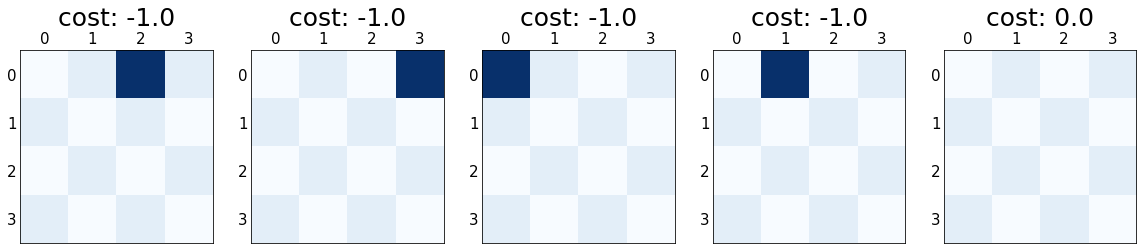

In [8]:
# 最適化ソルバーの初期化
solver = SimulatedBifurcationMachine(workspace)

# 解は5つ出力
solver.set_one_param('maxout', 5)

# 最適化の実行
result = solver.optimize(problem)

# SBM の実行時間
print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

# 探索された解の描画
draw_results(result)

描画結果から、探索された最適解は最初の行にクイーンが1つのみ配置されていることが確認できます。

<h3 style="color:#4080F0">4.1.3. Term への変換（全ての行）</h3>

今度は、全ての行に対して先ほどと同様に `Term` を記述し、制約1の `Term` への変換を完成させます。
ただし1行に対して10個の `Term` が必要になるため、全ての行に対しては合計40個の `Term` が必要になり、記述が非常に面倒です。
ここでは少し楽をするために、ある行 $i$ に対応する `Term` を全て生成してくれる関数 `get_terms_row()` を定義します。
このように、設計したハミルトニアンから多数の `Term` を生成していくことが、Azure Quantum を使うための作業の中核になります。
したがって、`Term` の生成を支援するような関数を作ることは重要です。

In [9]:
# 行数iに対応するTermを全て返す関数
def get_terms_row(i:int):
    terms = [
        Term(c=-1, indices=[x(i,0), x(i,0)]), # -1 * xi,0 * xi,0
        Term(c=-1, indices=[x(i,1), x(i,1)]), # -1 * xi,1 * xi,1
        Term(c=-1, indices=[x(i,2), x(i,2)]), # -1 * xi,2 * xi,2
        Term(c=-1, indices=[x(i,3), x(i,3)]), # -1 * xi,3 * xi,3
        Term(c=2, indices=[x(i,0), x(i,1)]), # 2 * xi,0 * xi,1
        Term(c=2, indices=[x(i,0), x(i,2)]), # 2 * xi,0 * xi,2
        Term(c=2, indices=[x(i,0), x(i,3)]), # 2 * xi,0 * xi,3
        Term(c=2, indices=[x(i,1), x(i,2)]), # 2 * xi,1 * xi,2
        Term(c=2, indices=[x(i,1), x(i,3)]), # 2 * xi,1 * xi,3
        Term(c=2, indices=[x(i,2), x(i,3)])  # 2 * xi,2 * xi,3
    ]

    return terms

Termの数:		40
.......
SBM実行時間（秒）:	0.007


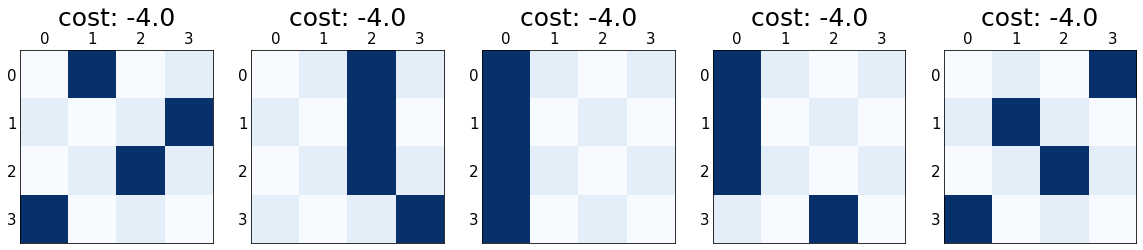

In [10]:
# クイーン数の設定
N = 4

# 問題に対応する Problem オブジェクトの初期化
problem = Problem(name="NQueen", problem_type=ProblemType.pubo)

# 各行に対応する Term 取得
terms_row_0 = get_terms_row(0)
terms_row_1 = get_terms_row(1)
terms_row_2 = get_terms_row(2)
terms_row_3 = get_terms_row(3)

# 取得した全ての Term をまとめる
terms = []
terms.extend(terms_row_0)
terms.extend(terms_row_1)
terms.extend(terms_row_2)
terms.extend(terms_row_3)

# Problem オブジェクトに Term を追加
problem.add_terms(terms=terms)

print("Termの数:\t\t" + str(len(problem.terms)))

# 最適化ソルバーの初期化
solver = SimulatedBifurcationMachine(workspace)

# 解は5つ出力
solver.set_one_param('maxout', 5)

# 最適化の実行
result = solver.optimize(problem)

print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

# 探索された解の描画
draw_results(result)

描画結果から、今度は全ての行に対してそれぞれクイーンが1つのみ配置されていることが確認できます。

<h3 style="color:#4080F0">4.1.4. 任意の N への対応</h3>

ここまでで、$N=4$ とした場合の `Term` への変換が行えるようになりました。
しかしこのままでは、$N$ が変化するたびにコードを書きなおす必要があります。
ここでは任意の $N$ に対応するために、ハミルトニアン $H_{row}$ の数式からコードを記述する方法について説明します。

ハミルトニアンにおける総和 $\Large\sum_{i=0}^{N-1}()$ は $0$ から $N-1$ までの $i$ に対して $()$ の中を処理し足し合わせているため、プログラミングにおける繰り返し文（for文）に対応づけることができます。
ただし元のハミルトニアン $H_{row}$ には複数の項を2乗する部分が含まれているため、まずはこれを展開してやる必要があります。

<br>

$$
\begin{align}
\Large H_{row} = &\Large A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}x_{ij}-1)^2 \\
\Large= &\Large A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}\sum_{k=0}^{N-1}x_{ij}x_{ik}-2\sum_{l=0}^{N-1}x_{il}+1)
\end{align}
$$

<br>

ここで新しい変数 $k,l$ が出てきていますが、これは $i,j$ と変数名が被らないようにしただけのものです。
この式は更に、$ x \in [0, 1] $ より $ x_{il} = x_{il}x_{il} $ が成り立つことから、$x_{ij}x_{ik}$ の項から $i=k$ となる場合を抜き出して $x_{il}x_{il}$ の項にまとめることができます。

<br>

$$
\begin{align}
\Large H_{row} = &\Large A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}\sum_{k=0}^{N-1}x_{ij}x_{ik}-2\sum_{l=0}^{N-1}x_{il}+1) \\
\Large= &\Large A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}\sum_{k=0}^{N-1}x_{ij}x_{ik}-2\sum_{l=0}^{N-1}x_{il}x_{il}+1) \\
\Large= &\Large A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}\sum_{k=0 \\ k \neq j}^{N-1}x_{ij}x_{ik}-\sum_{l=0}^{N-1}x_{il}x_{il}+1) \\
\end{align}
$$

<br>

また最後の $+1$ の項は変数 $x$ に依存しておらず、$x$ に対する最適化の議論では無視できるため、$H_{row}$ は改めて以下のように定義できます。

$$\Large H_{row} = A\sum_{i=0}^{N-1} (\sum_{j=0}^{N-1}\sum_{k=0 \\ k \neq j}^{N-1}x_{ij}x_{ik}-\sum_{l=0}^{N-1}x_{il}x_{il}) $$

これでfor文に書き直すことができる形のみで構成されたハミルトニアンになりました。
それでは実際に、制約1に対応する全ての `Term` を返す関数 `get_terms_constraint_1()` を定義してみましょう。
ただしここでは、先ほどは1に固定していた重み係数 $A$ を入力として与えられるようにしています。

In [11]:
# Aを入力として制約1に対応する全てのTermを返す関数
def get_terms_constraint_1(A:float):
    terms: List[Term] = []

    # 一番外側の総和に対応
    for i in range(N):

        # xij * xik の項に対応
        for j in range(N):
            for k in range(N):

                # k = j の場合は飛ばす
                if k == j:
                    continue

                # k != j の場合はTermを追加する
                terms.append(
                    Term(
                        c = A,
                        indices = [x(i, j), x(i, k)]
                    )
                )

        # xil * xil の項に対応
        for l in range(N):

            terms.append(
                Term(
                    c = -A,
                    indices = [x(i, l), x(i, l)]
                )
            )

    return terms

Termの数:		64
........
SBM実行時間（秒）:	0.007


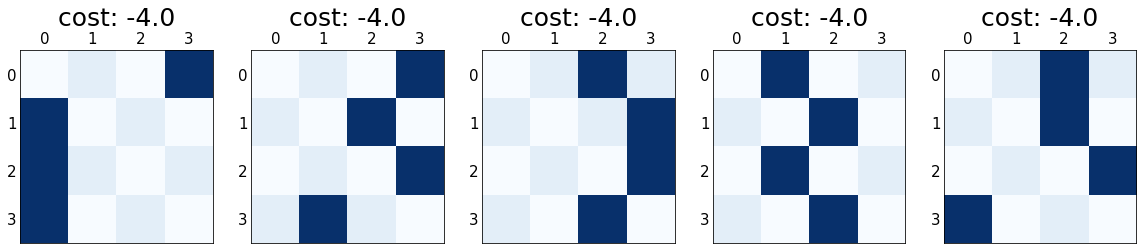

In [12]:
N = 4
A = 1.0

problem = Problem(name="NQueen", problem_type=ProblemType.pubo)

# Term 取得
terms = get_terms_constraint_1(A)

problem.add_terms(terms=terms)

solver = SimulatedBifurcationMachine(workspace)
solver.set_one_param('maxout', 5)

print("Termの数:\t\t" + str(len(problem.terms)))

result = solver.optimize(problem)

print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

draw_results(result)

描画結果から 4.1.3 項 と同様に、全ての行に対してそれぞれクイーンが1つのみ配置されていることが確認できます。

<h2 style="color:#3060C0">4.2. 【制約2】各列に配置するクイーンは1つのみ</h2>

<h3 style="color:#4080F0">4.2.1. ハミルトニアンの設計</h3>

2つ目の制約は、各列に配置するクイーンは1つのみという制約です。
図4の赤枠で囲った部分のように、各列に対しては $N$ 個の変数が存在しますが、この制約2を満たすためにはそのうち1つのみが1となる必要があります。
これは先ほどの制約1と全く同じ性質を持つ制約であり、制約1に対するハミルトニアン $H_{row}$ における $i$ と $j$ を入れ替えるだけで制約2のハミルトニアン $H_{column}$ を設計することができます。

$$ \Large H_{column} = B\sum_{j=0}^{N-1} (\sum_{i=0}^{N-1}x_{ij}-1)^2 $$

<center><img src="https://user-images.githubusercontent.com/41032487/157776753-29ea1879-2d61-4af9-91e3-27de9b58dc78.png"></center>
<center><h3>図.4 【制約2】各列に配置するクイーンは1つのみ</h3></center>

<h3 style="color:#4080F0">4.2.2. 任意の N に対応する関数の定義</h3>

$H_{column}$ も $H_{row}$ と同様に、全てfor文に書き直すことができる形に再定義することができます。
まず、$ x_{il} = x_{lj}x_{lj} $ が成り立つことから以下のように展開します。

<br>

$$
\begin{align}
    \Large H_{column} &\Large= B\sum_{j=0}^{N-1} (\sum_{i=0}^{N-1}x_{ij}-1)^2 \\ \\
    &\Large= B\sum_{j=0}^{N-1} (\sum_{i=0}^{N-1}\sum_{k=0}^{N-1}x_{ij}x_{kj}-2\sum_{l=0}^{N-1}x_{lj}+1) \\ \\
    &\Large= B\sum_{j=0}^{N-1} (\sum_{i=0}^{N-1}\sum_{k=0 \\ k \neq i}^{N-1}x_{ij}x_{kj}-\sum_{l=0}^{N-1}x_{lj}x_{lj}+1)
\end{align}
$$

<br>

さらに、最後の $+1$ の項は無視できるため、$H_{column}$ を以下のように再定義します。

$$ \Large H_{column} = B\sum_{j=0}^{N-1} (\sum_{i=0}^{N-1}\sum_{k=0 \\ k \neq i}^{N-1}x_{ij}x_{kj}-\sum_{l=0}^{N-1}x_{lj}x_{lj}) $$

これで、制約2に対するハミルトニアンの設計は完成です。
制約2に対する全ての `Term` を返す関数 `get_terms_constraint_2()` を先ほどのコードに加えた以下の一連のセルを実行し、制約1-2を満たす解が正しく出力されることを確認してください。

In [13]:
# Bを入力として制約2に対応する全てのTermを返す関数
def get_terms_constraint_2(B:float):
    terms: List[Term] = []

    # 一番外側の総和に対応
    for j in range(N):

        # xij * xkj の項に対応
        for i in range(N):
            for k in range(N):

                # k = i の場合は飛ばす
                if k == i:
                    continue

                # k != i の場合はTermを追加する
                terms.append(
                    Term(
                        c = B,
                        indices = [x(i, j), x(k, j)]
                    )
                )

        # xlj * xlj の項に対応
        for l in range(N):

            terms.append(
                Term(
                    c = -B,
                    indices = [x(l, j), x(l, j)]
                )
            )

    return terms

Termの数:		128
........
SBM実行時間（秒）:	0.007


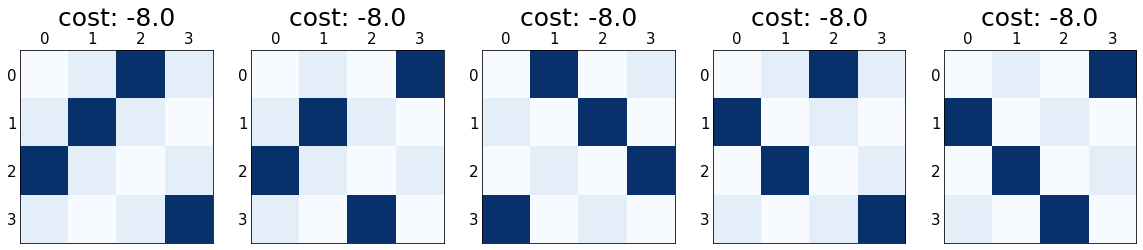

In [14]:
N = 4
A = 1.0
B = 1.0

problem = Problem(name="NQueen", problem_type=ProblemType.pubo)

# 制約1-2に対応するTermを取得
terms_constraint_1 = get_terms_constraint_1(A)
terms_constraint_2 = get_terms_constraint_2(B)

# 取得した全てのTermをまとめる
terms = []
terms.extend(terms_constraint_1)
terms.extend(terms_constraint_2)

problem.add_terms(terms=terms)

solver = SimulatedBifurcationMachine(workspace)
solver.set_one_param('maxout', 5)

print("Termの数:\t\t" + str(len(problem.terms)))

result = solver.optimize(problem)

print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

draw_results(result)

描画結果から今度は列に対しても制約が満たされた解が探索されたことが確認できます。

<h2 style="color:#3060C0">4.3. 【制約3】右上がりの斜線上に配置するクイーンは0または1つのみ</h2>

<h3 style="color:#4080F0">4.3.1. ハミルトニアンの設計</h3>

3つ目の制約は、斜めの線上に配置するクイーンは0または1つのみという制約です。ここではまず図5のように、右上がりの直線を考えます。
このとき、右上がりの直線上にある変数間ではインデックスの和 $i+j$ が等しくなるという特徴があります。
そこでまず、$i+j=1$ である図5の赤枠で囲まれた2つの変数について、満たすべき条件を考えてみます。

$$ \Large \sum_{i+j=1} = x_{1,0} + x_{0,1} = 0 \ or \ 1$$

これを元に、制約を満たしている場合に $H$ が最小となり、制約を破る場合に $H$ が増加するように、$i+j=1$ のみに対応するハミルトニアン $H_{diagonal\_up\_0}$ を設計します。

$$ \Large H_{diagonal\_up\_0} = \Large \sum_{i+j=1}\ \sum_{\begin{gather} I+J=1 \\ I\neq i \end{gather}} x_{ij}x_{IJ} $$

ここでは、インデックスの総和が1になるという条件を満たす2つの変数 $x_{ij},x_{IJ}$ について、それらを単純に掛けたものをハミルトニアンに加えています。
このようにすることで、右上がりの直線上にある2つのマスの両方にクイーンが置かれ、変数 $x_{ij},x_{IJ}$ がどちらも1になる場合にのみ $H$ が増加するように設計できます。
このとき、$x_{ij}$ と $x_{IJ}$ は別のマスに対応している必要があるため、$I \neq i$ の条件を加えています。

最後に、$i+j$ を $s$ と置き、$s=1$ である左上の直線から、$s=2N-3$となる右下の直線まで、全ての斜めの直線を対象とするハミルトニアン $H_{diagonal\_up}$ に拡張します。
（斜めの直線は $2N-1$ 本考えられますが、1マスのみが含まれる斜めの直線にはこの制約を考える意味はありませんので、$2N-3$ 本となります）

$$ \Large H_{diagonal\_up} = C\sum_{s=1}^{2N-3} \ \sum_{i+j=s} \ \sum_{\begin{gather} I+J=s \\ I\neq i \end{gather}} x_{ij}x_{IJ} $$

<center><img src="https://user-images.githubusercontent.com/41032487/157776754-c68d01fa-dd64-4f06-a4ee-9dea4a7725c3.png"></center>
<center><h3>図.5 【制約3】右上がりの斜線上に配置するクイーンは0または1つのみ</h3></center>

<h3 style="color:#4080F0">4.3.2. 任意のNに対応する関数の定義</h3>

設計した $H_{diagonal\_up}$ は総和のみで構成されているため、一見そのままfor文に書き直すことが出来るように思えます。
しかし制約1や2のように、チェス盤の行や列の番号を意味する $i,j,I,J$ の範囲をハミルトニアン上で定義していないため、$\sum_{i+j=s}$ のような総和式はそのままではfor文にすることが出来ません。
以下に示す制約3に対する全ての `Term` を返す関数 `get_terms_constraint_3()` の定義では、$i+j=s$ を $i$ の視点から、$I+J=s$ を $I$ の視点から考えてfor文を記述しています。

$$ \Large H_{diagonal\_up} = C\sum_{s=1}^{2N-3} \ \sum_{i+j=s} \ \sum_{\begin{gather} I+J=s \\ I \neq i \end{gather}} x_{ij}x_{IJ} $$

In [15]:
# Cを入力として制約3に対応する全てのTermを返す関数
def get_terms_constraint_3(C:float):
    terms: List[Term] = []

    # s の総和式に対応
    for s in range(1, 2*N-2):

        # i+j=s の総和式に対応
        for i in range(N):

            # i+j=s より
            j = s-i

            # j が条件を満たすか確認する
            if j < 0 or j > N-1:
                continue

            # I+J=s の総和式に対応
            for I in range(N):

                # I+J=s より
                J = s-I

                # I,J が条件を満たすか確認する
                if I == i or J < 0 or J > N-1:
                    continue

                terms.append(
                    Term(
                        c = C,
                        indices = [x(i, j), x(I, J)]
                    )
                )

    return terms

<h2 style="color:#3060C0">4.4. 【制約4】右下がりの斜線上に配置するクイーンは0または1つのみ</h2>

<h3 style="color:#4080F0">4.4.1. ハミルトニアンの設計</h3>

最後の制約は、制約3と同様に右下がりの直線上に配置するクイーンは0または1つのみという制約です。
この場合、図6の赤枠で囲った2つの変数 $x_{0,2}$ と $x_{1,3}$ のように、右下がりの直線状にある変数間ではインデックスの差 $i-j$ が等しくなるという特徴があります。
その他は制約3における考え方と全く変わらないため、制約4に対するハミルトニアン $H_{diagonal\_down}$ は以下のように設計できます。

$$ \Large H_{diagonal\_down} = D\sum_{s=-N+2}^{N-2} \ \sum_{i-j=s} \sum_{\begin{gather} I-J=s \\ I\neq i\end{gather}} x_{ij}x_{IJ} $$

<center><img src="https://user-images.githubusercontent.com/41032487/157776755-cf4b7b8b-071c-4200-b1ff-b0c9fef7a771.png"></center>
<center><h3>図.6 【制約4】右下がりの斜線上に配置するクイーンは0または1つのみ</h3></center>

<h3 style="color:#4080F0">4.4.2. 任意のNに対する関数の定義</h3>

制約4に対する全ての `Term` を返す関数 `get_terms_constraint_4()` に関しても、制約3と同様に定義することができます。

$$ \Large H_{diagonal\_down} = D\sum_{s=-N+2}^{N-2} \ \sum_{i-j=s} \sum_{\begin{gather} I-J=s \\ I\neq i\end{gather}} x_{ij}x_{IJ} $$

In [16]:
# Dを入力として制約4に対応する全てのTermを返す関数
def get_terms_constraint_4(D:float):
    terms: List[Term] = []

    # s の総和式に対応
    for s in range(-N+2, N-1):

        # i-j=s の総和式に対応
        for i in range(N):

            # i-j=s より
            j = i-s

            # j が条件を満たすか確認する
            if j < 0 or j > N-1:
                continue

            # I-J=s の総和式に対応
            for I in range(N):

                # I-J=s より
                J = I-s

                # I,J が条件を満たすか確認する
                if I == i or J < 0 or J > N-1:
                    continue

                terms.append(
                    Term(
                        c = D,
                        indices = [x(i, j), x(I, J)]
                    )
                )

    return terms

<h2 style="color:#3060C0">4.5. N クイーン問題に対するハミルトニアンの全体像</h2>

4.4 節により N クイーン問題の制約に対するハミルトニアンを全て設計することができました。
それらを全て足し合わせることで N クイーン問題に対するハミルトニアン $H_{NQueen}$ が完成します。

<br>

$$ \Large H_{NQueen} = H_{row}+H_{column}+H_{diagonal\_up}+H_{diagonal\_down} $$

<br>

最後に、各制約に対して今まで定義してきた `Term` オブジェクトを返す関数を利用しながら、全ての制約を満たす解を探索する最適化を実行します。
以下の手順に従い、最適解が正しく描画されるか確認してください。

<h4 style="color:#F06030">作業手順</h4>

1. 以下のコードが記述されたセルを実行する。
2. 最適解が描画されるか確認する。また描画結果に表示される `cost` が -8 になることを確認する。
3. セル内の N を 8 に変更し、同様に実行する。
4. 描画結果および `cost` が -16 になっていることを確認する。

Termの数:		1584
.......
SBM実行時間（秒）:	0.008


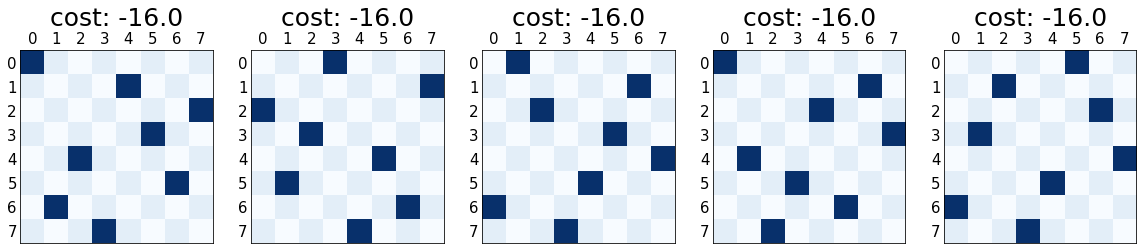

In [18]:
N = 8
A = 1.0
B = 1.0
C = 1.0
D = 1.0

problem = Problem(name="NQueen", problem_type=ProblemType.pubo)

# 制約1-4に対応するTermを取得
terms_constraint_1 = get_terms_constraint_1(A)
terms_constraint_2 = get_terms_constraint_2(B)
terms_constraint_3 = get_terms_constraint_3(C)
terms_constraint_4 = get_terms_constraint_4(D)

# 取得した全てのTermをまとめる
terms = []
terms.extend(terms_constraint_1)
terms.extend(terms_constraint_2)
terms.extend(terms_constraint_3)
terms.extend(terms_constraint_4)

problem.add_terms(terms=terms)

solver = SimulatedBifurcationMachine(workspace)
solver.set_one_param('maxout', 5)

print("Termの数:\t\t" + str(len(problem.terms)))

result = solver.optimize(problem)

print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

draw_results(result)

<h2 style="color:#3060C0">4.6. 重複するTermをまとめる</h2>

ここまで各制約に対して必要となる `Term` を作成する関数を定義してきましたが、作成される `Term` が重複しているかどうかは特に考えませんでした。
しかし、全く同じ `Term` が複数存在したり、 $x_{0,0}x_{0,1}$ と $x_{0,1}x_{0,0}$ のように実質的に同じ `Term` が存在してしまうと、問題の規模が大きくなった場合に最適化ソルバーの探索性能を低下させてしまう可能性があります。

このハンズオンでは問題の対処方法について詳細には説明しませんが、例えば以下の例では Python の辞書型を用いることで重複する `Term` を後からまとめています。
このようなテクニックは N クイーン問題に限らず、実際の問題を扱う多くの場合においても有効です。
以下の手順に従い、改善前と改善後で `Term` の数が半減していることを確認してみてください。

<h4 style="color:#F06030">作業手順</h4>

1. **従来の方法で Term を作成する場合** と書かれた次のセルを実行する。
2. 作成された `Term` の数を確認する。
3. **重複する Term を後からまとめる場合** と書かれた次の2つのセルを順番に実行する。
4. 作成された `Term` の数が減少しているかどうか確認する。
5. **正しく機能するか確認** と書かれた次のセルを実行する。
6. 描画結果から、`Term` の重複を排除して数が半減した状態でも正しく最適解が探索できているかどうか確認する。

<br>

<h3>従来の方法で Term を作成する場合</h3>

In [ ]:
N = 4
A = 1.0
B = 1.0
C = 1.0
D = 1.0

# 制約1-4に対応するTermを取得
terms_constraint_1 = get_terms_constraint_1(A)
terms_constraint_2 = get_terms_constraint_2(B)
terms_constraint_3 = get_terms_constraint_3(C)
terms_constraint_4 = get_terms_constraint_4(D)

# 取得した全てのTermをまとめる
terms = []
terms.extend(terms_constraint_1)
terms.extend(terms_constraint_2)
terms.extend(terms_constraint_3)
terms.extend(terms_constraint_4)

print("Termの数:\t\t" + str(len(terms)))

<h3>重複する Term を後からまとめる場合</h3>

In [19]:
from typing import Dict

# 辞書型を用いて重複するtermをまとめる関数
def add_terms(dict_terms: Dict[str, float], added_terms: List[Term]):
    
    for term in added_terms:
        ids0 = term.ids[0]
        ids1 = term.ids[1]

        key = ""
        if ids0 <= ids1:
            key = str(ids0) + "," + str(ids1)
        else:
            key = str(ids1) + "," + str(ids0)

        if key in dict_terms.keys():
            dict_terms[key] += term.c
        else:
            dict_terms[key] = term.c

# 辞書型に格納された情報からtermを構築する関数
def construct_terms(dict_terms: Dict[str, float]):
    terms: List[Term] = []

    for k,v in dict_terms.items():

        if v == 0:
            continue

        ids = k.split(",")
        terms.append(
            Term(
                c=v,
                indices=[int(ids[0]), int(ids[1])]
            )
        )

    return terms


In [ ]:
N = 4
A = 1.0
B = 1.0
C = 1.0
D = 1.0

# 制約1-4に対応するTermを取得
terms_constraint_1 = get_terms_constraint_1(A)
terms_constraint_2 = get_terms_constraint_2(B)
terms_constraint_3 = get_terms_constraint_3(C)
terms_constraint_4 = get_terms_constraint_4(D)

# 取得した全てのTermをまとめる
dict_terms:Dict[str, float] = {}
add_terms(dict_terms, terms_constraint_1)
add_terms(dict_terms, terms_constraint_2)
add_terms(dict_terms, terms_constraint_3)
add_terms(dict_terms, terms_constraint_4)

terms = construct_terms(dict_terms)

print("Termの数:\t\t" + str(len(terms)))

<h3>正しく機能するか確認</h3>

In [ ]:
problem = Problem(name="NQueen", problem_type=ProblemType.pubo)

problem.add_terms(terms=terms)

solver = SimulatedBifurcationMachine(workspace)
solver.set_one_param('maxout', 5)

print("Termの数:\t\t" + str(len(problem.terms)))

result = solver.optimize(problem)

print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

draw_results(result)

<h2 style="color:#3060C0">4.7. 解の多様性の確認</h2>

次に、SBM によって探索された解がどの程度多様性を持つか確認します。
例として、92個のユニークな解を持つ8クイーンを解いてみましょう。
SBM のパラメータは出力する解の個数のみ100とし、その他はデフォルトの値のままで最適化を行います。

In [20]:
N = 8
A = 1.0
B = 1.0
C = 1.0
D = 1.0

# 制約1-4に対応するTermを取得
terms_constraint_1 = get_terms_constraint_1(A)
terms_constraint_2 = get_terms_constraint_2(B)
terms_constraint_3 = get_terms_constraint_3(C)
terms_constraint_4 = get_terms_constraint_4(D)

# 取得した全てのTermをまとめる
dict_terms:Dict[str, float] = {}
add_terms(dict_terms, terms_constraint_1)
add_terms(dict_terms, terms_constraint_2)
add_terms(dict_terms, terms_constraint_3)
add_terms(dict_terms, terms_constraint_4)

terms = construct_terms(dict_terms)

problem = Problem(name="NQueen", problem_type=ProblemType.pubo)
problem.add_terms(terms=terms)

solver = SimulatedBifurcationMachine(workspace)

# 解を100個出力する
solver.set_one_param('maxout', 1000)

print("Termの数:\t\t" + str(len(problem.terms)))

result = solver.optimize(problem)

print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

Termの数:		792
........
SBM実行時間（秒）:	0.008


SBM の結果には全く同じ解は含まれないため、以下のように `cost` が-16となる最適解のみを考えることで、ユニークな解の数を数えることができます。

In [21]:
num_unique_solutions = 0

for solution in result['solutions']:
    if solution['cost'] == -16.0:
        num_unique_solutions += 1
    else:
        break

print("ユニークな解の数:\t" + str(num_unique_solutions) + " / 92")

ユニークな解の数:	39 / 92


最適化を実行する度に結果は異なりますが、多くの場合は数十パターンの最適解を得ることができます。
もちろん、SBM のパラメータを調整することでこのパターン数は更に増加させることが可能です。

<h2 style="color:#3060C0">4.8. より大規模な問題の実行</h2>

最後に、N=50としたより大規模な問題（50クイーン問題）を実行してみましょう。
クイーン数 $N$ に対して二値変数の数は $N^2$ となるため、$N$ が増加すると問題の規模は途端に大きくなります
（別の言い方をすれば、 $N$ が増加するにしたがって探索すべき組み合わせが指数関数的に増える問題に対して、準備すべき二値変数の個数は、たかが2乗のオーダーでしか増加しないということでもあります）。
下表のように、N=50の場合はN=4と比較して150倍以上の二値変数、2,000倍以上の `Term` が必要となります。

|N|二値変数の数|Term の数|
|-:|-:|-:|
|4|16|92|
|8|64|792|
|50|2,500|205,850|

そのため、これまでと同様にパラメータをデフォルトのままセルを実行すると、`cost` が-100となる最適解が探索されない場合があります。
そこで、チュートリアルで説明したように SBM に対して `target` と `loops` パラメータを指定し、`target` に指定した値の `cost` を持つ解が探索されるまで計算を繰り返すように設定してみましょう。
以下の手順に従い、一部のパラメータを調整することで最適解が探索されるかどうか確認してください。

<h4 style="color:#F06030">作業手順</h4>

1. パラメータをデフォルトのまま用いている以下のセルをそのまま実行する。
2. 描画結果を確認し、`cost` が-100となる最適解が探索されたかどうか確認する。
3. コメントアウトされている2行の最初の `#` を削除し、`target` と `loops` を設定する。
4. 改めてセルを実行し、最適解が探索されたかどうか確認する。

Termの数:		205850
..........
SBM実行時間（秒）:	3.727


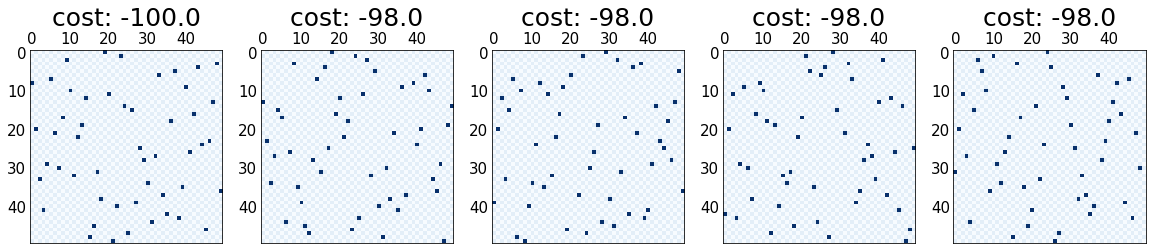

In [22]:
N = 50
A = 1.0
B = 1.0
C = 1.0
D = 1.0

problem = Problem(name="NQueen", problem_type=ProblemType.pubo)

terms_constraint_1 = get_terms_constraint_1(A)
terms_constraint_2 = get_terms_constraint_2(B)
terms_constraint_3 = get_terms_constraint_3(C)
terms_constraint_4 = get_terms_constraint_4(D)

dict_terms:Dict[str, float] = {}
add_terms(dict_terms, terms_constraint_1)
add_terms(dict_terms, terms_constraint_2)
add_terms(dict_terms, terms_constraint_3)
add_terms(dict_terms, terms_constraint_4)

terms = construct_terms(dict_terms)

problem.add_terms(terms=terms)

solver = SimulatedBifurcationMachine(workspace)
solver.set_one_param('maxout', 5)
solver.set_one_param('target', -100)
solver.set_one_param('loops', 0)

print("Termの数:\t\t" + str(len(problem.terms)))

result = solver.optimize(problem)

print("\nSBM実行時間（秒）:\t" + str(result['solutions'][0]['parameters']['time']))

draw_results(result)

<h3>【参考論文】</h3>

\[1] M. Kajiura, Y. Akiyama and Y. Anzai, "Solving large scale puzzles with neural networks" In *IEEE International Workshop on Tools for Artificial Intelligence*, 1989, pp. 562-569. [https://ieeexplore.ieee.org/document/65368](https://ieeexplore.ieee.org/document/65368)